# Developing a Probabilistic Programming Language

In this lecture we'll see how one might approach developing *from scratch* a probabilistic programming language (PPL) that allows (and here we'll restrict ourself a bit...):
1. expressing any probabilistic program (PP) from a particular family;
2. performing inference using stochastic variational inference (SVI) by:
    1. first, defining a different PP as the variational distribution parameterized by a set of variational parameters;
    2. and second, minimizing $-ELBO$ through SGD over the variational parameters.

This lecture follows mainly [Mini-Pyro](https://pyro.ai/examples/minipyro.html), a minimalist didactic implementation of Pyro PPL, and a few other examples from the Pyro documentation. We'll go together through the Mini-Pyro code and see how a PPL implementation works under the hood.

Prerequisites include advanced knowledge of Python and previous contact with probabilistic programming and Pyro.   

# The Building Blocks of Our PPL

## Stochastic Primitives
Stochastic primitives, also called Elementary Random Procedures (ERP) are a set of functions/services that a PPL offers that fulfill fundamental operations:
 + sampling;
 + conditioning on data (observations);
 + declaring a variable a parameter admitting optimization (the parameter is learnable).

## Distributions
We assume that the various probability distributions $d_i$ we use to define our model $p_{\theta} (\mathbf{x}, \mathbf{z})$ have the following properties (speaking from a computational/implementation point of view):
 - we can sample from each $d_i$;
 - we can compute the pointwise log pdf $\log d_i$;
 - is differentiable w.r.t. the parameters $\theta$.

## Defining Models
A model is fundamentally an implementation of a stochastic function taking some arguments. We can thus treat it as any other function, but its outputs are going to be stochastic, i.e. they'll likely change from one function call to another. Calling this function effectively corresponds to sampling from it.

## Defining the Public Interface of the Library
Let our library be called `minipyro`. For any numerical work (e.g. calculating gradients, etc.) we'll rely on PyTorch, while for probability distributions we'll depend on Pyro.

Let sampling be done through a call to:
```python
def sample(name, fn, *args, **kwargs):
    ...
```
And let conditioning be done through an optional argument to `sample`:
```python
minipyro.sample("rv_1", fn=..., obs=some_data)
```
The argument `fn` is a distribution object satisfying the above implementation requirements.

Sampling without conditioning corresponds to declaring a RV latent (i.e. $\mathbf{z}$), while sampling with conditioning declares it observed (i.e. $\mathbf{x}$). The two together allow us to create generic probabilistic models.

# A Bayesian Modelling Problem
To test our PPL, and as an aid in defining the library's public interface, we'll develop a simple Bayesian linear regression model.

We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable `rugged` in the dataset) and its GDP per capita. In particular, it was noted by the authors of the original paper (“Ruggedness: The blessing of bad geography in Africa”) [4] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations.

Let us look at the data and investigate this relationship. We will be focusing on three features from the dataset:
 - `rugged`: quantifies the Terrain Ruggedness Index;
 - `cont_africa`: whether the given nation is in Africa;
 - `rgdppc_2000`: Real GDP per capita for the year 2000.

In [2]:
# Install dependencies
!pip install torch
!pip install pyro-ppl
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 6.6 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.distributions import constraints

import pyro.distributions as dist

In [4]:
# Download data
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

# Select only the columns we need
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
# Clean values
df = df[np.isfinite(df.rgdppc_2000)]
# Take the log GDP
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

# Transform into a torch.Tensor (for later)
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

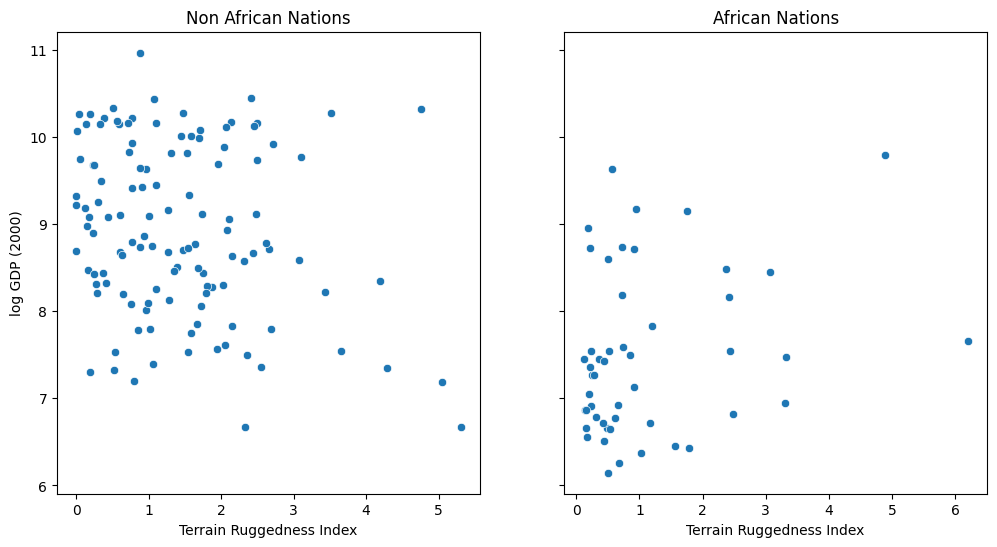

In [6]:
# Plot the data for African nations and non-African nations
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]

sns.scatterplot(
    x=non_african_nations["rugged"],
    y=non_african_nations["rgdppc_2000"],
    ax=ax[0]
)
ax[0].set(
    xlabel="Terrain Ruggedness Index",
    ylabel="log GDP (2000)",
    title="Non African Nations"
)
sns.scatterplot(
    x=african_nations["rugged"],
    y=african_nations["rgdppc_2000"],
    ax=ax[1]
)
_ = ax[1].set(
    xlabel="Terrain Ruggedness Index",
    ylabel="log GDP (2000)",
    title="African Nations"
)

Using our `minipyro` primitives, we can define the model...

```python
def bayesian_lr_model(is_cont_africa, ruggedness, log_gdp):
    # Sample intercept
    a = minipyro.sample("a", dist.Normal(0., 10.))
    
    # Sample regression coefficients
    b_a = minipyro.sample("bA", dist.Normal(0., 1.))
    b_r = minipyro.sample("bR", dist.Normal(0., 1.))
    b_ar = minipyro.sample("bAR", dist.Normal(0., 1.))
    
    # Mean and std dev of the response variable
    sigma = minipyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    
    # Declare data conditionally independent
    with minipyro.plate("data", len(ruggedness), dim=-1):
        minipyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
```

Here we've added another library function - plates. They are syntactic sugar for declaring a dimension conditionally independent, and could in principle be replaced by a `for` loop.

## Defining a Variational Family, Variational Distribution, and Variational Parameters

We take the same approach for the variational distribution as for the model. We define it as a stochastic function with **sample** statements, but with two distinctions:
 1. Recall that the variational distribution $q (\mathbf{z})$ is defined only over the latent variables $\mathbf{z}$. Hence, we can't have observed sampled variables.
 2. We declare learnable parameters that parameterise the distributions of sample statements over $\mathbf{z}$. We can implement this with the **param** primitive function:
    ```python
        def param(
            name, init_value, constraint,
        )
     ```
     Parameters can be explicitly constrained to various subsets of $\mathbb{R}^n$ by using torch.distributions.constraints.Constraint.
 3. sample statements in the variational distribution implementation need to correspond by name to the latent variables in the defined model.

For our example let us choose a mean field variational distribution. That is, we assume that the variational distribution factorizes as:
$$
    q(z_1, \dots, z_m) = \prod_{i=1}^m q(z_i)
$$

```python
def bayesian_lr_var_dist(is_cont_africa, ruggedness, log_gdp):
    # Intercept distribution parameters
    a_loc = minipyro.param(
        'a_loc', torch.tensor(0.)
    )
    a_scale = minipyro.param(
        'a_scale', torch.tensor(1.), constraint=constraints.positive
    )
    
    # Std dev parameter
    sigma_loc = minipyro.param(
        'sigma_loc', torch.tensor(1.), constraint=constraints.positive
    )
    
    # Regression coefficients distribution parameters
    weights_loc = minipyro.param(
        'weights_loc', torch.randn(3)
    )
    weights_scale = minipyro.param(
        'weights_scale', torch.ones(3), constraint=constraints.positive
    )
    
    # Sample from the variational distribution using the variational parameters
    a = minipyro.sample("a", dist.Normal(a_loc, a_scale))
    
    b_a = minipyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = minipyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = minipyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    
    sigma = minipyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    
    # mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
```

# Inference
We have thus far defined the model and the variational distribution as stochastic functions using stochastic primitives of our library. Now we form the necessary abstractions for inference, where we'll consider three components:
 - **the optimizer** - responsible for keeping track of parameter values and updating their values based on the computed gradients
 - **the objective function** - the ELBO
 - **the object abstracting inference** - `SVI` class taking the model, the VD, optimizer and objective function, and handling all computation given some data.


```python
svi = minipyro.SVI(
    bayesian_lr_model,
    bayesian_lr_var_dist,
    minipyro.Adam({"lr": .05}),
    loss=minipyro.Trace_ELBO()
)

minipyro.clear_param_store()

NUM_ITERATIONS = 5000

for i in range(NUM_ITERATIONS):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        print(f"Elbo loss: {elbo}")
```

# Implementing `minipyro`

This is the conceptual scheme of our library's internal implementation:

<img src="img/library_architecture.jpg">

Now we can start implementing the library.

First we import all the necessry modules. We'll depend only on NumPy and Torch for numerical work.

In [7]:
import weakref
from collections import OrderedDict

import torch

We'll keep track of two kinds of global state (module level, and thus also library level):
 -  The effect handler stack, which enables non-standard interpretations of stochastic primitives like `sample()`
 -  Trainable parameters

In [8]:
MINIPYRO_STACK = []
PARAM_STORE = {}  # maps name -> (unconstrained_value, constraint)


def get_param_store():
    return PARAM_STORE

def clear_param_store():
    PARAM_STORE = {}

We'll use the effect handler pattern for the processing stack.

In [9]:
# The base effect handler class.
class Messenger:
    def __init__(self, fn=None):
        self.fn = fn

    # Effect handlers push themselves onto the MINIPYRO_STACK.
    # Handlers later in the MINIPYRO_STACK are applied first.
    def __enter__(self):
        MINIPYRO_STACK.append(self)

    def __exit__(self, *args, **kwargs):
        assert MINIPYRO_STACK[-1] is self
        MINIPYRO_STACK.pop()

    def process_message(self, msg):
        pass

    def postprocess_message(self, msg):
        pass

    def __call__(self, *args, **kwargs):
        with self:
            return self.fn(*args, **kwargs)

A **trace** of a probabilistic program is the set of sampled values, and is our first useful example of an effect handler. `trace` records the inputs and outputs of any primitive site it encloses, and returns a dictionary containing that data to the user.

In [10]:
class trace(Messenger):
    def __enter__(self):
        super().__enter__()
        self.trace = OrderedDict()
        return self.trace

    # trace illustrates why we need postprocess_message in addition to process_message:
    # We only want to record a value after all other effects have been applied
    def postprocess_message(self, msg):
        assert (
            msg["type"] != "sample" or msg["name"] not in self.trace
        ), "sample sites must have unique names"

        self.trace[msg["name"]] = msg.copy()

    def get_trace(self, *args, **kwargs):
        self(*args, **kwargs)

        return self.trace

A second example of an effect handler for setting the value at a sample site. We can compose trace and replay to replace values but preserve distributions, allowing us to compute the joint probability density of samples under a model. See the definition of `elbo()` below for an example of this pattern.

In [11]:
class replay(Messenger):
    def __init__(self, fn, guide_trace):
        self.guide_trace = guide_trace
        super().__init__(fn)

    def process_message(self, msg):
        if msg["name"] in self.guide_trace:
            msg["value"] = self.guide_trace[msg["name"]]["value"]


`block` allows the selective application of effect handlers to different parts of a model. Sites hidden by block will only have the handlers below block on the `MINIPYRO_STACK` applied, allowing inference or other effectful computations to be nested inside models.

In [12]:
class block(Messenger):
    def __init__(self, fn=None, hide_fn=lambda msg: True):
        self.hide_fn = hide_fn
        super().__init__(fn)

    def process_message(self, msg):
        if self.hide_fn(msg):
            msg["stop"] = True

PlateMessenger allows us to have syntactic sugar for `for` loops. In more "able" PPLs, it has positive repercussions on inference and performance.

In [13]:
class PlateMessenger(Messenger):
    def __init__(self, fn, size, dim):
        assert dim < 0
        self.size = size
        self.dim = dim
        super().__init__(fn)

    def process_message(self, msg):
        if msg["type"] == "sample":
            batch_shape = msg["fn"].batch_shape
            if len(batch_shape) < -self.dim or batch_shape[self.dim] != self.size:
                batch_shape = [1] * (-self.dim - len(batch_shape)) + list(batch_shape)
                batch_shape[self.dim] = self.size
                msg["fn"] = msg["fn"].expand(torch.Size(batch_shape))

    def __iter__(self):
        return range(self.size)


def plate(name, size, dim=None):
    if dim is None:
        raise NotImplementedError("plate requires a dim arg")
    return PlateMessenger(fn=None, size=size, dim=dim)

# `sample` and `param` - The Stochastic Primitives

`apply_stack` is called by `minipyro.sample` and `minipyro.param`. It is responsible for applying each Messenger to each effectful operation.

In [14]:

def apply_stack(msg):
    # MINIPYRO_STACK is reversed so that effect handlers higher
    # in the stack are first applied.
    for pointer, handler in enumerate(reversed(MINIPYRO_STACK)):
        handler.process_message(msg)

        # When a Messenger sets the "stop" field of a message,
        # it prevents any Messengers below it on the stack from being applied.
        if msg.get("stop"):
            break

    if msg["value"] is None:
        msg["value"] = msg["fn"](*msg["args"])

    # A Messenger that sets msg["stop"] == True also prevents application
    # of postprocess_message by Messengers below it on the stack
    # via the pointer variable from the process_message loop
    for handler in MINIPYRO_STACK[-pointer - 1 :]:
        handler.postprocess_message(msg)

    return msg

`sample` is an effectful version of `Distribution.sample(...)`. When any effect handlers are active, it constructs an initial message and calls `apply_stack`.

In [15]:
def sample(name, fn, *args, **kwargs):
    obs = kwargs.pop("obs", None)

    # if there are no active Messengers, we just draw a sample and return it as expected:
    if not MINIPYRO_STACK:
        return fn(*args, **kwargs)

    # Otherwise, we initialize a message...
    initial_msg = {
        "type": "sample",
        "name": name,
        "fn": fn,
        "args": args,
        "kwargs": kwargs,
        "value": obs,
    }

    # ...and use apply_stack to send it to the Messengers
    msg = apply_stack(initial_msg)

    return msg["value"]

`param` is an effectful version of `PARAM_STORE.setdefault` that also handles constraints. When any effect handlers are active, it constructs an initial message and calls `apply_stack`.

In [16]:
def param(
    name,
    init_value=None,
    constraint=torch.distributions.constraints.real,
    event_dim=None,
):
    if event_dim is not None:
        raise NotImplementedError("plate does not support the event_dim arg")

    def fn(init_value, constraint):
        if name in PARAM_STORE:
            unconstrained_value, constraint = PARAM_STORE[name]
        else:
            # Initialize with a constrained value.
            assert init_value is not None
            with torch.no_grad():
                constrained_value = init_value.detach()
                unconstrained_value = torch.distributions.transform_to(constraint).inv(
                    constrained_value
                )
            unconstrained_value.requires_grad_()
            PARAM_STORE[name] = unconstrained_value, constraint

        # Transform from unconstrained space to constrained space.
        constrained_value = torch.distributions.transform_to(constraint)(
            unconstrained_value
        )
        constrained_value.unconstrained = weakref.ref(unconstrained_value)

        return constrained_value

    # if there are no active Messengers, we just draw a sample and return it as expected:
    if not MINIPYRO_STACK:
        return fn(init_value, constraint)

    # Otherwise, we initialize a message...
    initial_msg = {
        "type": "param",
        "name": name,
        "fn": fn,
        "args": (init_value, constraint),
        "value": None,
    }

    # ...and use apply_stack to send it to the Messengers
    msg = apply_stack(initial_msg)

    return msg["value"]

# Optimization and Inference

We borrow our optimizer from PyTorch. This is a thin wrapper around the `torch.optim.Adam` class that
dynamically generates optimizers for dynamically generated parameters.

In [17]:
class Adam:
    def __init__(self, optim_args):
        self.optim_args = optim_args

        # Each parameter will get its own optimizer, which we keep track
        # of using this dictionary keyed on parameters.
        self.optim_objs = {}

    def __call__(self, params):
        for param in params:
            # If we've seen this parameter before, use the previously
            # constructed optimizer.
            if param in self.optim_objs:
                optim = self.optim_objs[param]

            # If we've never seen this parameter before, construct
            # an Adam optimizer and keep track of it.
            else:
                optim = torch.optim.Adam([param], **self.optim_args)
                self.optim_objs[param] = optim

            # Take a gradient step for the parameter param.
            optim.step()

The `SVI` class is a unified interface for stochastic variational inference. Through the method `step()` it handles:
+ running the model and guide;
+ constructing the loss function;
+ and taking a gradient step over the parameters.

In [18]:
class SVI:
    def __init__(self, model, guide, optim, loss):
        self.model = model
        self.guide = guide
        self.optim = optim
        self.loss = loss

    def step(self, *args, **kwargs):
        # This wraps both the call to `model` and `guide` in a `trace` so that
        # we can record all the parameters that are encountered. Note that
        # further tracing occurs inside of `loss`.
        with trace() as param_capture:
            # We use block here to allow tracing to record parameters only.
            with block(hide_fn=lambda msg: msg["type"] == "sample"):
                loss = self.loss(self.model, self.guide, *args, **kwargs)

        # Differentiate the loss.
        loss.backward()

        # Grab all the parameters from the trace.
        params = [site["value"].unconstrained() for site in param_capture.values()]

        # Take a step w.r.t. each parameter in params.
        self.optim(params)

        # Zero out the gradients so that they don't accumulate.
        for p in params:
            p.grad = torch.zeros_like(p)

        return loss.item()


This is a basic implementation of the **Evidence Lower Bound**, which is the
fundamental objective in Variational Inference. Recall that the ELBO can be expressed as:
$$
    \textrm{ELBO} = \mathbb{E}_{q_{\lambda} (\mathbf{z})} \left[ \log p_{\theta} (\mathbf{x}, \mathbf{z}) - \log q_{\lambda} (\mathbf{z}) \right]
$$

This implementation has various limitations. For example, it only supports random variables with reparameterized samplers.

Fundamentally we want to compute unbiased estimates of
$$
    \nabla_{\theta, \lambda} \textrm{ELBO} = \nabla_{\theta, \lambda} \mathbb{E}_{q_{\lambda} (\mathbf{z})} \left[ \log p_{\theta} (\mathbf{x}, \mathbf{z}) - \log q_{\lambda} (\mathbf{z}) \right]
$$
Reparameterizable distributions are such that for a generic cost function $f(\mathbf{z})$ and parameters $\phi$ the following will hold [5]:
$$
    \mathbb{E}_{q_{\phi} (\mathbf{z})} \left[ f_{\phi}(\mathbf{z}) \right] = \mathbb{E}_{q (\epsilon)} \left[ f_{\phi} (g_{\phi} (\epsilon) ) \right]
$$
This allows easy passage of the gradient through the expectation:
$$
    \nabla_{\phi} \mathbb{E}_{q_{\phi} (\mathbf{z})} \left[ f_{\phi}(\mathbf{z}) \right] = \mathbb{E}_{q (\epsilon)} \left[ \nabla_{\phi} f_{\phi} (g_{\phi} (\epsilon) ) \right]
$$
An example of a reparameterizable distribution is a Gaussian, where a valid reparameterization could be:
$$
    z = \mu + \sigma \epsilon
$$
where $\epsilon \sim \mathcal{N} \left( 0, 1 \right)$.

In [19]:
def elbo(model, guide, *args, **kwargs):
    # Run the guide with the arguments passed to SVI.step() and trace the execution,
    # i.e. record all the calls to stochastic primitives like sample() and param().
    guide_trace = trace(guide).get_trace(*args, **kwargs)

    # Now run the model with the same arguments and trace the execution. Because
    # model is being run with replay, whenever we encounter a sample site in the
    # model, instead of sampling from the corresponding distribution in the model,
    # we instead reuse the corresponding sample from the guide. In probabilistic
    # terms, this means our loss is constructed as an expectation w.r.t. the joint
    # distribution defined by the guide.
    model_trace = trace(replay(model, guide_trace)).get_trace(*args, **kwargs)

    # We will accumulate the various terms of the ELBO in `elbo`.
    elbo = 0.0

    # Loop over all the sample sites in the model and add the corresponding
    # log p(z) term to the ELBO. Note that this will also include any observed
    # data, i.e. sample sites with the keyword `obs=...`.
    for site in model_trace.values():
        if site["type"] == "sample":
            elbo = elbo + site["fn"].log_prob(site["value"]).sum()

    # Loop over all the sample sites in the guide and add the corresponding
    # -log q(z) term to the ELBO.
    for site in guide_trace.values():
        if site["type"] == "sample":
            elbo = elbo - site["fn"].log_prob(site["value"]).sum()

    # Return (-elbo) since by convention we do gradient descent on a loss and
    # the ELBO is a lower bound that needs to be maximized.
    return -elbo


# This is a wrapper for ease of use.
def Trace_ELBO(**kwargs):
    return elbo

In [20]:
def predictive(model, guide, site_name, num_steps, *args, **kwargs):
    # Run the guide with the arguments passed to SVI.step() and trace the execution,
    # i.e. record all the calls to stochastic primitives like sample() and param().

    site_vals = list()
    for _ in range(num_steps):
        guide_trace = trace(guide).get_trace(*args, **kwargs)
        model_trace = trace(replay(model, guide_trace)).get_trace(*args, **kwargs)

        for site in model_trace.values():
            if site["name"] == site_name:
                site_vals.append(site["value"].detach().numpy())

    return {
        site_name: site_vals
    }

In [21]:
import sys

# Make a container object to "pretend" as if minipyro is a library living in a separate module we imported...
class minipyrocontainerclass:
    def __getattr__(self, item):
        current_module = sys.modules[__name__]
        return current_module.__getattribute__(item)

minipyro = minipyrocontainerclass()

# Running Our Bayesian Linear Regression Model with `minipyro`

In [23]:
def bayesian_lr_model(is_cont_africa, ruggedness, log_gdp):
    # Sample intercept
    a = minipyro.sample("a", dist.Normal(0., 10.))

    # Sample regression coefficients
    b_a = minipyro.sample("bA", dist.Normal(0., 1.))
    b_r = minipyro.sample("bR", dist.Normal(0., 1.))
    b_ar = minipyro.sample("bAR", dist.Normal(0., 1.))

    # Mean and std dev of the response variable
    sigma = minipyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    # Declare data conditionally independent
    with minipyro.plate("data", len(ruggedness), dim=-1):
        minipyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

In [24]:
def bayesian_lr_var_dist(is_cont_africa, ruggedness, log_gdp):
    # Intercept distribution parameters
    a_loc = minipyro.param(
        'a_loc', torch.tensor(0.)
    )
    a_scale = minipyro.param(
        'a_scale', torch.tensor(1.), constraint=constraints.positive
    )

    # Std dev parameter
    sigma_loc = minipyro.param(
        'sigma_loc', torch.tensor(1.), constraint=constraints.positive
    )

    # Regression coefficients distribution parameters
    weights_loc = minipyro.param(
        'weights_loc', torch.randn(3)
    )
    weights_scale = minipyro.param(
        'weights_scale', torch.ones(3), constraint=constraints.positive
    )

    # Sample from the variational distribution using the variational parameters
    a = minipyro.sample("a", dist.Normal(a_loc, a_scale))

    b_a = minipyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = minipyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = minipyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))

    sigma = minipyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    # mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness


In [25]:
svi = minipyro.SVI(
    bayesian_lr_model,
    bayesian_lr_var_dist,
    minipyro.Adam({"lr": .05}),
    loss=minipyro.Trace_ELBO()
)

minipyro.clear_param_store()

NUM_ITERATIONS = 5000

for i in range(NUM_ITERATIONS):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        print(f"Iteration {i}; Elbo loss: {elbo}")

Iteration 0; Elbo loss: 3809.184326171875
Iteration 500; Elbo loss: 410.9007873535156
Iteration 1000; Elbo loss: 251.5400848388672
Iteration 1500; Elbo loss: 248.0323028564453
Iteration 2000; Elbo loss: 249.7968292236328
Iteration 2500; Elbo loss: 248.74557495117188
Iteration 3000; Elbo loss: 249.31861877441406
Iteration 3500; Elbo loss: 247.38232421875
Iteration 4000; Elbo loss: 248.93350219726562
Iteration 4500; Elbo loss: 248.73974609375


In [26]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [27]:
svi_samples = predictive(bayesian_lr_model, bayesian_lr_var_dist, "obs", 1000, is_cont_africa, ruggedness, None)
pred_summary = summary(svi_samples)

In [28]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values.head(), "\n")

Site: obs
       mean       std        5%       25%       50%       75%        95%
0  7.507939  0.959033  5.905266  6.858928  7.503061  8.189681   9.047575
1  8.547182  0.984913  6.941469  7.886556  8.550893  9.234608  10.119872
2  9.025437  0.973502  7.420267  8.363486  9.068588  9.660020  10.608958
3  9.025156  0.946403  7.490665  8.421101  9.024262  9.614285  10.564786
4  8.693033  0.965117  7.095392  8.018700  8.693711  9.330423  10.269370 



In [29]:
y = pred_summary["obs"]

predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": log_gdp,
})

african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])

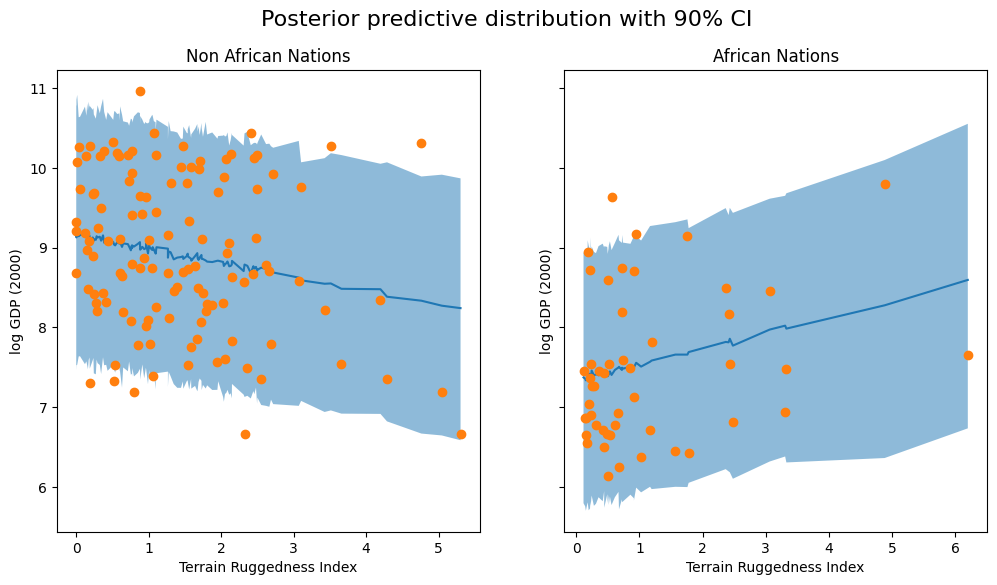

In [30]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), sharey=True
)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(
    non_african_nations["rugged"],
    non_african_nations["y_mean"]
)
ax[0].fill_between(
    non_african_nations["rugged"],
    non_african_nations["y_perc_5"],
    non_african_nations["y_perc_95"],
    alpha=0.5
)
ax[0].plot(
    non_african_nations["rugged"],
    non_african_nations["true_gdp"],
    "o"
)
ax[0].set(
    xlabel="Terrain Ruggedness Index",
    ylabel="log GDP (2000)",
    title="Non African Nations"
)
idx = np.argsort(african_nations["rugged"])

ax[1].plot(
    african_nations["rugged"],
    african_nations["y_mean"]
)
ax[1].fill_between(
    african_nations["rugged"],
    african_nations["y_perc_5"],
    african_nations["y_perc_95"],
    alpha=0.5
)
ax[1].plot(
    african_nations["rugged"],
    african_nations["true_gdp"],
    "o"
)
_ = ax[1].set(
    xlabel="Terrain Ruggedness Index",
    ylabel="log GDP (2000)",
    title="African Nations"
)


# Mini-Pyro to Pyro
What we've just managed to develop is a working bare-bones implementation of Pyro, a well known PPL in Python built on the shoulders of PyTorch that focuses mainly on SVI as an inference method. Nonetheless, it also supports various other MCMC inference algorithms.

In fact, our model should work perfectly well in Pyro if we just replace `minipyro` for `pyro` (in most cases...).

In [31]:
import pyro
import pyro.optim as optim
import pyro.infer as infer

In [32]:
def bayesian_lr_model(is_cont_africa, ruggedness, log_gdp):
    # Sample intercept
    a = pyro.sample("a", dist.Normal(0., 10.))

    # Sample regression coefficients
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))

    # Mean and std dev of the response variable
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    # Declare data conditionally independent
    with pyro.plate("data", len(ruggedness), dim=-1):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

In [33]:
def bayesian_lr_var_dist(is_cont_africa, ruggedness, log_gdp):
    # Intercept distribution parameters
    a_loc = pyro.param(
        'a_loc', torch.tensor(0.)
    )
    a_scale = pyro.param(
        'a_scale', torch.tensor(1.), constraint=constraints.positive
    )

    # Std dev parameter
    sigma_loc = pyro.param(
        'sigma_loc', torch.tensor(1.), constraint=constraints.positive
    )

    # Regression coefficients distribution parameters
    weights_loc = pyro.param(
        'weights_loc', torch.randn(3)
    )
    weights_scale = pyro.param(
        'weights_scale', torch.ones(3), constraint=constraints.positive
    )

    # Sample from the variational distribution using the variational parameters
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))

    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))

    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    # mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness


In [34]:
svi = infer.SVI(
    bayesian_lr_model,
    bayesian_lr_var_dist,
    optim.Adam({"lr": .05}),
    loss=infer.Trace_ELBO()
)

pyro.clear_param_store()

NUM_ITERATIONS = 5000

for i in range(NUM_ITERATIONS):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        print(f"Iteration {i}; Elbo loss: {elbo}")

Iteration 0; Elbo loss: 8589.913793802261
Iteration 500; Elbo loss: 437.1825833916664
Iteration 1000; Elbo loss: 266.55098551511765
Iteration 1500; Elbo loss: 254.55198484659195
Iteration 2000; Elbo loss: 248.54102963209152
Iteration 2500; Elbo loss: 250.08058273792267
Iteration 3000; Elbo loss: 249.67870086431503
Iteration 3500; Elbo loss: 247.81313353776932
Iteration 4000; Elbo loss: 249.15652507543564
Iteration 4500; Elbo loss: 249.13781142234802


In [35]:
NUM_SAMPLES = 1000
predictive = infer.Predictive(bayesian_lr_model, guide=bayesian_lr_var_dist, num_samples=NUM_SAMPLES)
svi_samples = {
    k: v.reshape(NUM_SAMPLES, -1).detach().cpu().numpy()
    for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
    # if k != "obs"
}
pred_summary = summary(svi_samples)

In [36]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%       75%      95%
0  9.187384  0.075576  9.066562  9.133457  9.184195  9.237264  9.31929 

Site: bA
       mean       std        5%       25%       50%       75%       95%
0 -1.847021  0.113376 -2.033107 -1.919838 -1.846142 -1.770915 -1.656694 

Site: bR
       mean       std        5%       25%      50%       75%       95%
0 -0.178419  0.037268 -0.239595 -0.205232 -0.17662 -0.153131 -0.116262 

Site: bAR
      mean       std        5%       25%       50%      75%       95%
0  0.29197  0.063286  0.190993  0.246419  0.293804  0.33467  0.395727 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.975712  0.049716  0.896912  0.942135  0.974649  1.008421  1.056756 

Site: obs
         mean  std     5%    25%    50%    75%    95%
0    0.858000  0.0  0.858  0.858  0.858  0.858  0.858
1    3.427001  0.0  3.427  3.427  3.427  3.427  3.427
2    0.769000  0.0  0.769  0.769  0.769  0.769  0.769
3   

In [37]:
y = pred_summary["obs"]

predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": log_gdp,
})

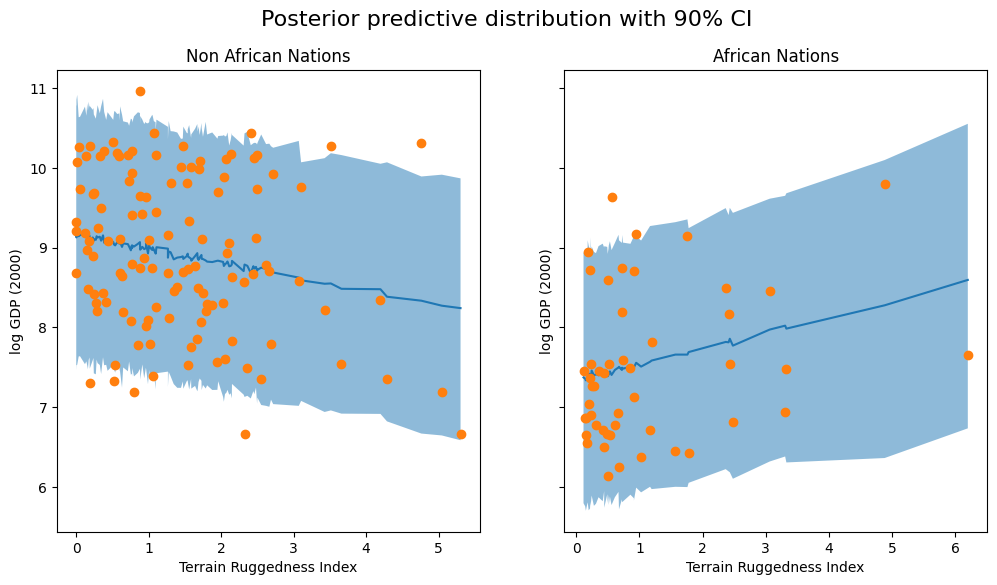

In [39]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), sharey=True
)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(
    non_african_nations["rugged"],
    non_african_nations["y_mean"]
)
ax[0].fill_between(
    non_african_nations["rugged"],
    non_african_nations["y_perc_5"],
    non_african_nations["y_perc_95"],
    alpha=0.5
)
ax[0].plot(
    non_african_nations["rugged"],
    non_african_nations["true_gdp"],
    "o"
)
ax[0].set(
    xlabel="Terrain Ruggedness Index",
    ylabel="log GDP (2000)",
    title="Non African Nations"
)
idx = np.argsort(african_nations["rugged"])

ax[1].plot(
    african_nations["rugged"],
    african_nations["y_mean"]
)
ax[1].fill_between(
    african_nations["rugged"],
    african_nations["y_perc_5"],
    african_nations["y_perc_95"],
    alpha=0.5
)
ax[1].plot(
    african_nations["rugged"],
    african_nations["true_gdp"],
    "o"
)
_ = ax[1].set(
    xlabel="Terrain Ruggedness Index",
    ylabel="log GDP (2000)",
    title="African Nations"
)

# Comparing the Mean Field Variational Inference (MFVI) Posterior to a Hamiltonian Monte Carlo (HMC) Posterior

In [40]:
nuts_kernel = infer.NUTS(bayesian_lr_model)

mcmc = infer.MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(is_cont_africa, ruggedness, log_gdp)

hmc_samples = {
    k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()
}

Sample: 100%|██████████| 1200/1200 [00:58, 20.56it/s, step size=3.62e-01, acc. prob=0.929]


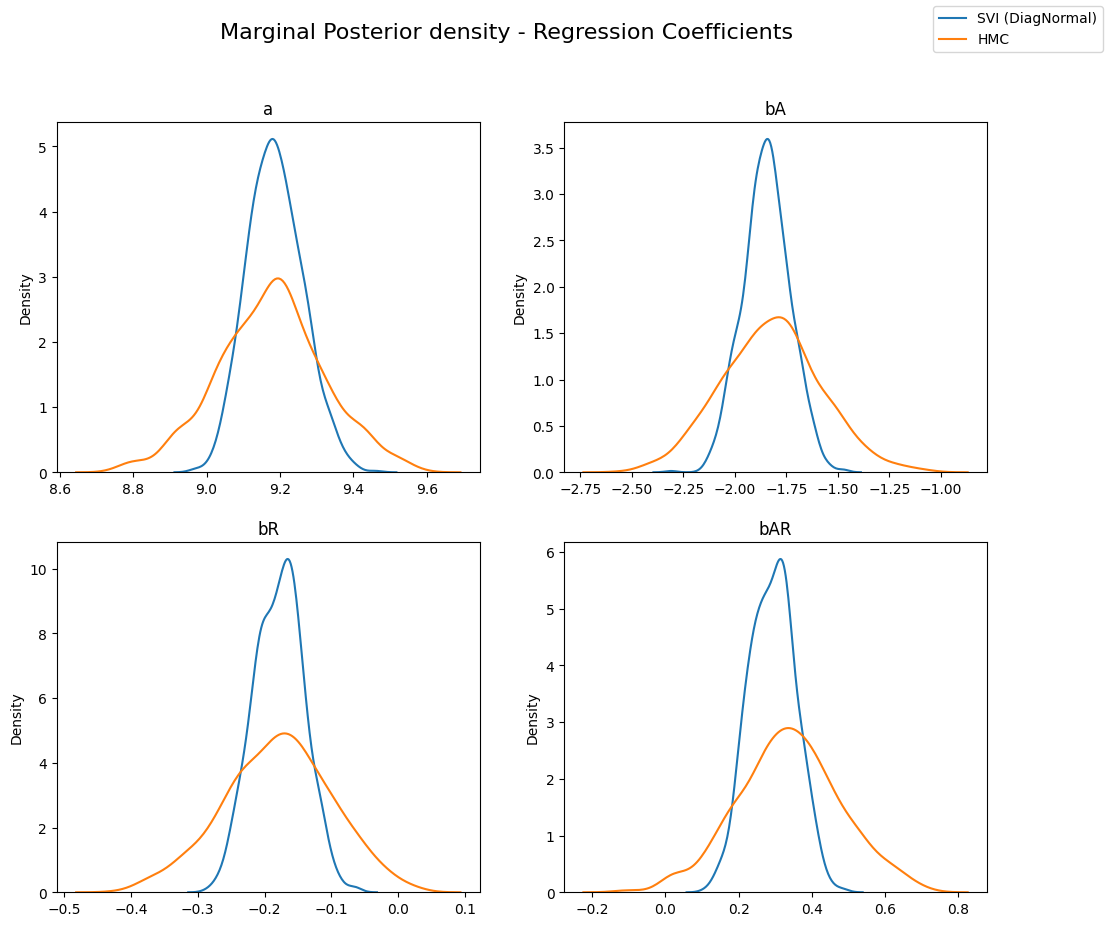

In [60]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)

for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.kdeplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)", legend=False)
    sns.kdeplot(hmc_samples[site], ax=ax, label="HMC", legend=False)
    ax.set_title(site)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

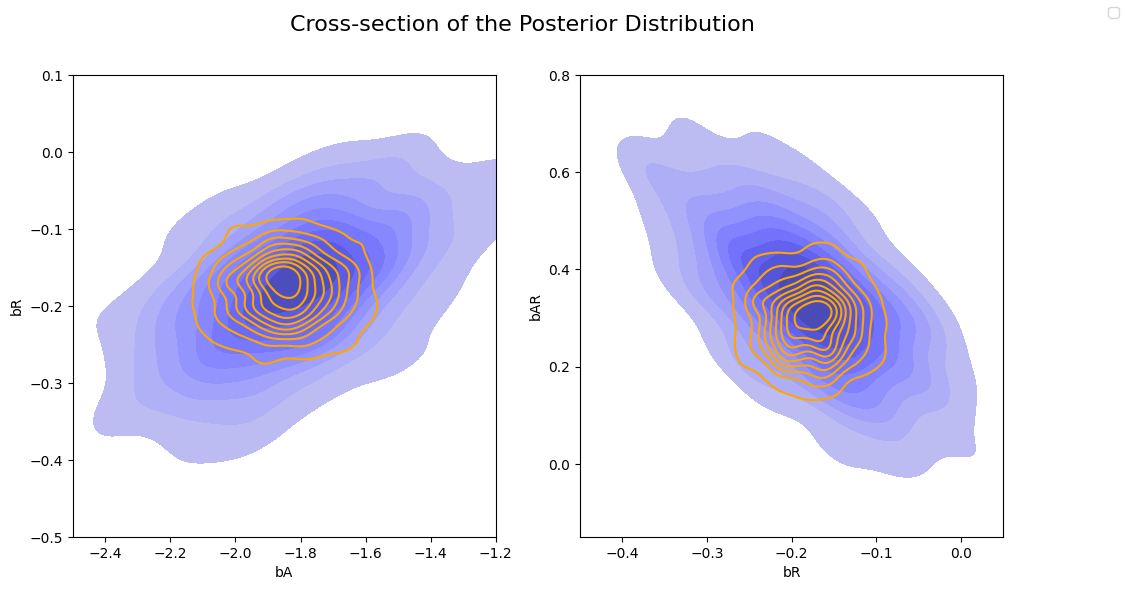

In [79]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)

sns.kdeplot(x=hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], fill=True, label="HMC", color="blue")
sns.kdeplot(x=svi_samples["bA"].squeeze(), y=svi_samples["bR"].squeeze(), ax=axs[0], label="SVI (DiagNormal)", color="orange")

axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))

sns.kdeplot(x=hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], fill=True, label="HMC", color="blue")
sns.kdeplot(x=svi_samples["bR"].squeeze(), y=svi_samples["bAR"].squeeze(), ax=axs[1], label="SVI (DiagNormal)", color="orange")

axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))

handles, labels = axs[1].get_legend_handles_labels()
_ = fig.legend(handles, labels, loc='upper right')

# References

[1] Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.

[2] Blei, D. M., Kucukelbir, A., & McAuliffe, J. D. (2017). Variational inference: A review for statisticians. Journal of the American statistical Association, 112(518), 859-877.

[3] Ranganath, R., Gerrish, S., & Blei, D. (2014, April). Black box variational inference. In Artificial intelligence and statistics (pp. 814-822). PMLR.

[4] Nunn, N., & Puga, D. (2012). Ruggedness: The blessing of bad geography in Africa. Review of Economics and Statistics, 94(1), 20-36.

[5] Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.


## Code and examples adapted from:

https://pyro.ai/examples/intro_long.html

https://pyro.ai/examples/svi_part_i.html

https://pyro.ai/examples/svi_part_iii.html

https://pyro.ai/examples/minipyro.html

https://pyro.ai/examples/bayesian_regression.html

https://pyro.ai/examples/bayesian_regression_ii.html
